# 言語処理100本ノック 2020 第８章

Reference: https://nlp100.github.io/ja/ch08.html

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from nltk.tokenize import word_tokenize
from gensim import corpora
from sklearn.preprocessing import OneHotEncoder

## 70. 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．

In [3]:
train = pd.read_csv("NewsAggregatorDataset/train.txt", sep="\t")
test = pd.read_csv("NewsAggregatorDataset/test.txt", sep="\t")
valid = pd.read_csv("NewsAggregatorDataset/valid.txt", sep="\t")
train.head()

,TITLE,CATEGORY
0,Shia Labeouf - Shia Labeouf In Rehab - Report,e
1,UPDATE 1-China bans use of Microsoft's Windows...,t
2,Mischa Barton Stuns In Flattering Black Dress,e
3,Aereo's Legal Battles Rest on the Meaning of '...,e
4,Ohio Mumps Outbreak Up To 56 Reported Cases,m


In [4]:
# Tokenize
tokens = [word_tokenize(text) for text in train.TITLE]
# Remove (i) numbers, (ii) single-character words
tokens = [[t for t in token if (not t.isnumeric()) and (len(t) > 1)] for token in tokens]
# Create dictionary
dictionary = corpora.Dictionary(tokens)
print(dictionary)

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)
print(dictionary)

Dictionary(19395 unique tokens: ['In', 'Labeouf', 'Rehab', 'Report', 'Shia']...)
Dictionary(1894 unique tokens: ['In', 'Report', 'Shia', "'s", '1-China']...)


In [5]:
def vectorize(texts, dictionary):
    # Tokenize
    tokens = [word_tokenize(text) for text in texts]
    # Vectorize
    corpus = [dictionary.doc2bow(t) for t in tokens]
    # 
    mat = pd.DataFrame(np.zeros([len(tokens), len(dictionary)]), 
                       columns=dictionary.token2id.keys())
    for i,c_s in enumerate(corpus):
        idx = [c[0] for c in c_s]
        mat.iloc[i, idx] = 1
    return(mat)

x_train = vectorize(train.TITLE, dictionary)
x_test = vectorize(test.TITLE, dictionary)
x_valid = vectorize(valid.TITLE, dictionary)
x_train.iloc[:5, :5]

,In,Report,Shia,'s,1-China
0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [6]:
#b = business, t = science and technology, e = entertainment, m = health
y_dict = {"b":0, "t":1, "e":2, "m":3}
y_train = [y_dict[c] for c in train.CATEGORY]
y_test = [y_dict[c] for c in test.CATEGORY]
y_valid = [y_dict[c] for c in valid.CATEGORY]
y_train[:5]

[2, 1, 2, 2, 3]

## 71. 単層ニューラルネットワークによる予測

問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

In [7]:
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader

torch.manual_seed(123) # torch用の乱数シード
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class TestModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, output_dim)
        self.layers = [self.l1]
        nn.init.uniform_(self.l1.weight, -1, 1)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
model = TestModel(x_train.shape[1], 4).to(device)
x_ = torch.Tensor(np.array(x_train)).to(device)
y_ = torch.Tensor(y_train).to(device)

In [10]:
model.forward(x_)

tensor([[ 2.5144,  0.3729,  0.7250, -1.3400],
        [-2.4293, -1.1343,  0.9164, -1.8876],
        [ 2.4407,  0.7129, -0.8651, -1.5174],
        ...,
        [-1.5226, -0.1192,  1.4111, -0.0818],
        [ 0.5885,  1.3574,  1.5553,  1.5798],
        [ 2.0930, -2.3336, -0.0579, -1.4801]], grad_fn=<AddmmBackward>)

## 72. 損失と勾配の計算

学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される．

In [11]:
# 損失関数
criterion = nn.CrossEntropyLoss()
def compute_loss(t, y):
    return criterion(y, t)

In [12]:
preds = model.forward(x_)
loss = compute_loss(y_.long(), preds) # long型にしないとエラーが出る
loss

tensor(2.2120, grad_fn=<NllLossBackward>)

## 73. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）

In [17]:
# Model
model = TestModel(x_train.shape[1], 4).to(device)

# Optimmizer
optimizer = optimizers.SGD(model.parameters(), lr=0.1)

# Dataset
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = torch.Tensor(np.array(x)).to(device)
        self.y = torch.Tensor(y).long().to(device)
        self.transform = transform
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        x_out = self.x[idx]
        y_out = self.y[idx]
        if self.transform:
            x_out = self.transform(x_out)
        return x_out, y_out
train_dataset = TestDataset(x_train, y_train)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [18]:
def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds   

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
epochs = 100
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=1).tolist())
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    if(epoch % 10 == 0 or epoch == epochs-1):
        print('epoch: {}, loss: {:.3}, acc: {:.3f}'.format(epoch+1, train_loss, train_acc ))

epoch: 1, loss: 1.63, acc: 0.387
epoch: 11, loss: 1.01, acc: 0.632
epoch: 21, loss: 0.831, acc: 0.693
epoch: 31, loss: 0.723, acc: 0.733
epoch: 41, loss: 0.648, acc: 0.765
epoch: 51, loss: 0.594, acc: 0.788
epoch: 61, loss: 0.552, acc: 0.807
epoch: 71, loss: 0.519, acc: 0.818
epoch: 81, loss: 0.492, acc: 0.831
epoch: 91, loss: 0.469, acc: 0.839
epoch: 100, loss: 0.451, acc: 0.846


## 74. 正解率の計測

問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [21]:
def val_step(x, t):
    model.eval() # Evaluation mode
    preds = model(x)
    loss = criterion(preds, t)
    return loss, preds

In [28]:
# 学習データ
x_ = torch.Tensor(np.array(x_train)).to(device)
y_ = torch.Tensor(y_train).long().to(device)
loss, preds = val_step(x_, y_)
accuracy_score(y_.tolist(), preds.argmax(dim=1).tolist())

0.8458583208395802

In [29]:
# 評価データ
x_ = torch.Tensor(np.array(x_test)).to(device)
y_ = torch.Tensor(y_test).long().to(device)
loss, preds = val_step(x_, y_)
accuracy_score(y_.tolist(), preds.argmax(dim=1).tolist())

0.8043478260869565

## 75. 損失と正解率のプロット

問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ

In [35]:
# 初期化
model = TestModel(x_train.shape[1], 4).to(device)
optimizer = optimizers.SGD(model.parameters(), lr=0.1)

# DataLoader
train_dataset = TestDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
# 
test_dataset = TestDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

epochs = 100
performance = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
for epoch in range(epochs):
    # 訓練データ
    train_loss = 0.
    train_acc = 0.
    for (x, t) in train_dataloader:
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=1).tolist())
    performance["train_loss"].append(train_loss / len(train_dataloader))
    performance["train_acc"].append(train_acc / len(train_dataloader))
    # テストデータ
    test_loss = 0.
    test_acc = 0.
    for (x, t) in test_dataloader:
        loss, preds = val_step(x, t)
        test_loss += loss.item()
        test_acc += accuracy_score(t.tolist(), preds.argmax(dim=1).tolist())
    performance["test_loss"].append(test_loss / len(test_dataloader))
    performance["test_acc"].append(test_acc / len(test_dataloader))
     
performance = pd.DataFrame(performance)
performance.head()

,train_loss,train_acc,test_loss,test_acc
0,1.551608,0.393915,1.338029,0.483487
1,1.310742,0.507347,1.211908,0.541261
2,1.220071,0.554403,1.140417,0.570588
3,1.158996,0.583146,1.087468,0.606134
4,1.113525,0.601116,1.060651,0.619874


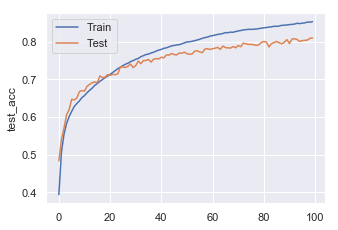

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.rcParams['figure.figsize'] = (5, 3.5)
sns.lineplot(x=performance.index, y=performance.train_acc)
sns.lineplot(x=performance.index, y=performance.test_acc)
plt.legend(["Train", "Test"])

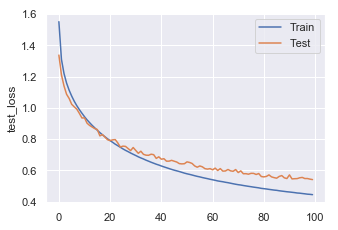

In [48]:
plt.rcParams['figure.figsize'] = (5, 3.5)
sns.lineplot(x=performance.index, y=performance.train_loss)
sns.lineplot(x=performance.index, y=performance.test_loss)
plt.legend(["Train", "Test"])

## 76. チェックポイント

問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

device(type='cpu')

## 77. ミニバッチ化

問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [53]:
import time
batches = [1,2,4,8,16,32,64,128,256,512,1024,2048]
times = []
for B in batches:
    t1 = time.time()
    # 初期化
    model = TestModel(x_train.shape[1], 4).to(device)
    optimizer = optimizers.SGD(model.parameters(), lr=0.1)

    # DataLoader
    train_dataset = TestDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)

    epochs = 1
    performance = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
    for epoch in range(epochs):
        # 訓練データ
        train_loss = 0.
        train_acc = 0.
        for (x, t) in train_dataloader:
            loss, preds = train_step(x, t)
            train_loss += loss.item()
            train_acc += accuracy_score(t.tolist(), preds.argmax(dim=1).tolist())
    times.append(time.time() - t1)
result = pd.DataFrame({"Batch_size":batches, "Time":times})
result

,Batch_size,Time
0,1,5.017787
1,2,2.645120
2,4,1.343209
3,8,0.818023
4,16,0.585411
5,32,0.412479
6,64,0.338303
7,128,0.274113
8,256,0.257899
9,512,0.244774


## 78. GPU上での学習

問題77のコードを改変し，GPU上で学習を実行せよ．


In [ ]:
# device = torch.device('cuda')

## 79. 多層ニューラルネットワーク

問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．